<a href="https://colab.research.google.com/github/ruygonzalez/tSNE/blob/master/tSNE_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tSNE Implementation
Ruy Gonzalez Hermosillo

# This is the implementation of tSNE from scratch, based on Algorithm 1 in the tSNE paper: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

First, we implement tSNE. Technically, first we import packages, then we define some helper functions to keep the tSNE code more consise

In [0]:
# Import packages to help with the matrix algebra/random number generation
# along with the plotting
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.spatial import distance
import random
import math

random.seed(2020)
np.random.seed(2020)

In [0]:
# Note that we calculate pairwise Euclidean distance several times, 
# but this can be done using Matrix multiplication (so that we can do it faster)
# The math comes from: https://math.stackexchange.com/questions/3147549/compute-the-pairwise-euclidean-distance-matrix/3147556
# Basically the distance matrix D = ||X||^2 + ||(X^T)^2|| - 2XX^T
# Where X represents the points we want to compute the distance between
# So D[i][j] = the squared Euclidean distance between X_i and X_j

def getSquaredDistanceMatrix(X):
    X_sq = np.sum(np.square(X), 1) # this is ||X||^2
    return X_sq + (X_sq - 2 * np.dot(X, X.T)).T

# This function calculates the perplexity
def getPerplexity(distance_matrix, sigma, i):
    # First we have to find the conditional probability matrix 
    # using the given distance matrix and sigma
   
    # x now contains the terms in the exponent 
    x = (-distance_matrix) / (2. * np.square(sigma))

    # We exponentiate
    e_x = np.exp(x)
    
    # we get errors when we take the log of zero
    # so we add a small constant for stability
    e_x = e_x + (10 ** (-10))
    
    # we divide every entry by the sum
    P = e_x / e_x.sum(axis = 1).reshape([-1, 1])
    
    # calculate the Shannon entropy
    H_p = -np.sum(P * np.log2(P), 1)
    perplexity = 2 ** H_p
    
    # we also return the ith row which is the row we want to use if the perplexity
    # is close to what we want
    return perplexity
    

# This function finds the desired sigma for a given row using binary search
# (finds the sigma that gets us close to the desired perplexity)
def findSigma(distance_matrix, perp, i):
    epsilon = 10 ** (-4)
    iters = 0 # we want to limit the number of iterations too so we don't get stuck
        
    lower_bound = 10 ** (-8)
    upper_bound = 10 ** (3)
    sigma = (lower_bound + upper_bound) / 2.0
    this_perplexity = getPerplexity(distance_matrix[i:i + 1, :], sigma, i)
        
    while (abs(this_perplexity - perp) > epsilon and iters < 100):
        if (this_perplexity > perp):
            upper_bound = sigma
        else:
            lower_bound = sigma
        sigma = (lower_bound + upper_bound) / 2.0
        this_perplexity = getPerplexity(distance_matrix[i:i + 1, :], sigma, i)
        iters += 1
    return sigma

# Now we can simply go through each row (cell) and find the optimal sigma
# (but more importantly, the conditonal probability row using this sigma)
# and this makes up P
def getP(data, perp):
    distance_matrix = getSquaredDistanceMatrix(data)
    
    (n, _) = data.shape
    sigmas = []
    for i in range(n):
        sigmas.append(findSigma(distance_matrix, perp, i))
    
    # Now we have the distance matrix and the sigmas
    # we can do some linear algebra to get P
    # Note that this code is identical to how we calcualte perplexity
    # since calculating perplexity involves building this matrix 
    # although there we only do it for one row
    x = -distance_matrix / (2. * np.square(np.array(sigmas).reshape((-1, 1))))
    P = np.exp(x)
    
    # we make sure the diagonals are zero
    np.fill_diagonal(P, 0.)
        
    # Note that we make this symmetric in the tSNE method
    # so the last step is to divide each entry by the sum of the entries in P
    P /= P.sum(axis = 1)
    return P

In [0]:
def getQ(Y):
    # Here we compute the 2-d affinities using equation 4 in the paper
    Q = np.zeros((len(Y), len(Y)))
    
    # First, we compute the numerator of each q_ij: (1 + ||y_i - y_j||^2)^-1
    for i in range(len(Q)):
        for j in range(len(Q)):
            if (i == j):
                Q[i][j] = 0
            else:
                Q[i][j] = np.power(1.0 + (distance.euclidean(Y[i], Y[j]) ** 2), -1)
    
    # Now we divide by the sum of all the entries in Q
    Q = Q / np.sum(Q)
    return Q

In [0]:
def getGrad(P, Q, Y):
    # Here we compute the gradient using equation 5 in the paper
    grad = []
    PminQ = P - Q # each entry is P_ij - Q_ij
    (r, c) = P.shape # note that this should be a square matrix
    
    for i in range(r):
        total = np.zeros(2)
        for j in range(c):
            term = PminQ[i][j] * (Y[i] - Y[j])
            term /= (1 + (distance.euclidean(Y[i], Y[j]) ** 2))
            total += term
        total *= 4
        # Now we add this 2-d vector (terms) to the gradient vector
        grad.append(total)
    return grad

In [0]:
def tsne(data, perp, num_iter, learning_rate):
    '''
    Input: 
    data is a matrix where cells are rows and gene expression (or any features) are columns
    perp is an integer representing the perplexity used to find the sigmas
    num_iter is an integer representing the number of iterations for the stochastic gradient descent
    learning_rate is a float used to modify the low-dimensional representation 
    
    Output: 
    The low dimensional data representation. This is another matrix where cells are columns, but with only 2 rows
    (since we want a 2-D representation of the data)
    '''
    
    (n, _) = data.shape # this gets the number of cells
    
    # first we compute pairwise affinities p_j|i
    P = getP(data, perp)
    
    # next we make it symmetric
    P = (P + np.transpose(P)) / (2 * n)
    
    # Next, we initialize a random low-dimensional (2-d) representation
    # with small initial values
    Y = np.random.rand(n, 2) / 10000.0 # this is to get very small values
    
    # Now we actually do the gradient descent 
    for i in range(num_iter):
        # The t-SNE paper suggests "early exaggeration" at the beginning of P
        # so we do that before anything else 
        if (i == 0):
            P = P * 4
        # but we have to reverse this eventually, we arbitrarily do this once
        # we have gone through 1/10th of the total iterations
        if (i == int(num_iter / 10)):
            P = P / 4
        
        # we compute the 2-d affinities q_ij
        Q = getQ(Y)
        
        # we compute the gradient 
        grad = getGrad(P, Q, Y)

        # Now we update Y
        Y -= learning_rate * np.asarray(grad)
    
    return Y

# Synthetic Data Generation from 3 Component Gaussian Mixture Model

Now we generate points from a 3 components Gaussian Mixture Model

In [0]:
def generatePoints(n, centroids, covs, weight1=1, weight2=1, weight3=1):
    '''
    Generates n points from a 3-component Gaussian Mixture model using the 
    array of covariances and centroids for each model
    The weights are how much we weigh each distribution relative to the others. 
    By default they are all weighted the same (so a cell is equally likely
    to have come from each of the distributions)
    One more thing: we want to keep the labels (what distribution each point came from)
    this lets us visualize better
    '''
    # First, we pick one of the three distributions
    # The way we do this is by having an array of "balls" where each 
    # distribution has a number of balls equal to their weight (parameter)
    # so if the weight is 1 for all, then there are 3 balls, each equally
    # likely to be chosen (and thus each distribution is equally likely to be chosen)
    # If there are 2 balls for distribution 1 and 1 for each of the other 2
    # then there are 4 balls total and distribution 1 has a probability of 2/4
    # of being chosen
    balls = []
    # we label each "ball" by the distribution we represent
    for i in range(weight1):
        balls.append(0) # we zero index the distributions
    for i in range(weight2):
        balls.append(1)
    for i in range(weight3):
        balls.append(2)
        
    chosen = [[] for x in range(n)]
    labels = []
    # Now we sample a "ball" or distribution randomly (we do this n times to get n points)
    for i in range(n):
        index = random.choice(balls) # this is the index of the chosen distribution
        cent = centroids[index]
        cov = covs[index]
        # Now we generate 10 random numbers using a multivariate normal distribution
        # with the chosen centroid and covariance
        chosen[i] = np.random.multivariate_normal(cent, cov).tolist()
        labels.append(index)
    return np.asarray(chosen), np.asarray(labels)

In [0]:
centroids = [[0,0,0,0,0,0,0,0,0,0], [15,3,15,3,15,3,15,3,15,3], [3,15,3,15,3,15,3,15,3,15]]
covs = [np.diag((1, 1, 1, 1, 1, 1, 1, 1, 1, 1)), np.diag((1, 2, 3, 4, 5, 6, 7, 8, 9, 10)), np.diag((10, 9, 8, 7, 6, 5, 4, 3, 2, 1))]

In [0]:
synthetic_data1, labels1 = generatePoints(400, centroids, covs)

In [0]:
# first we choose a perplexity of 5 and a learning rate of 10
Y1 = tsne(synthetic_data1, 5, 200, 10)

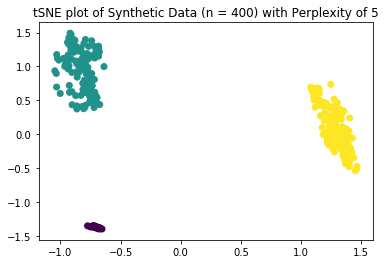

In [0]:
x1 = Y1[:, 0]
y1 = Y1[:, 1]
plt.figure()
plt.scatter(x1, y1, c=labels1)
plt.title("tSNE plot of Synthetic Data (n = 400) with Perplexity of 5")
plt.show()

In [0]:
# Now we choose a perplexity of 50 and a learning rate of 10
Y2 = tsne(synthetic_data1, 50, 200, 10)

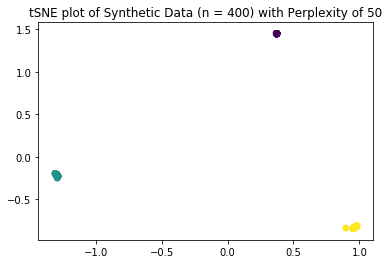

In [0]:
x2 = Y2[:, 0]
y2 = Y2[:, 1]
plt.figure()
plt.scatter(x2, y2, c=labels1)
plt.title("tSNE plot of Synthetic Data (n = 400) with Perplexity of 50")
plt.show()

# PCA of Synthetic Data

Now we do PCA

In [0]:
# First, we mean center the data
# We do this by updating each row (subtracting the row mean from each value in the row)
D = np.transpose(synthetic_data1).copy()
for row_index in range(len(D)):
    row_mean = np.mean(synthetic_data1[:,row_index])
    D[row_index,:] = [x - row_mean for x in synthetic_data1[:,row_index]]
    
# Now we calculate the mean-centered co-variance matrix
# Note that we have m = 400 total cells
m = 400
sigma = (1.0 / (m - 1)) * (np.matmul(D, np.transpose(D)))

In [0]:
eig_values, eig_vectors = np.linalg.eig(sigma)
# this is to sort the eigen values/vecotrs
idx = eig_values.argsort()[::-1]   
eigenValues = eig_values[idx]
eigenVectors = eig_vectors[:,idx]

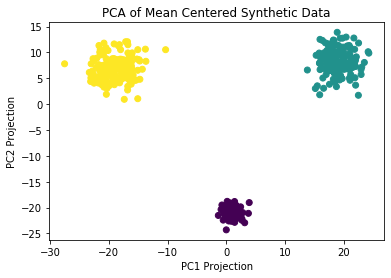

In [0]:
# Here we project the mean centered data D along the first and second eigenvectors
projection_pc1 = np.matmul(np.transpose(eigenVectors[:,0]), D)
projection_pc2 = np.matmul(np.transpose(eigenVectors[:,1]), D)

plt.figure()
plt.scatter(projection_pc1, projection_pc2, c=labels1)
plt.xlabel("PC1 Projection")
plt.ylabel("PC2 Projection")
plt.title("PCA of Mean Centered Synthetic Data")
plt.show()

# Synthetic Data with Variance

Now we generate synthetic data where one of the components in the Gaussian Mixture model has higher variance compared to the other two (we also have a "medium variance" component and "low variance" component" for comparison)

In [0]:
centroids2 = [[-15,-15,-15,-15,-15,-15,-15,-15,-15,-15], [15,3,15,3,15,3,15,3,15,3], [3,15,3,15,3,15,3,15,3,15]]
covs2 = [np.diag((10, 11, 12, 13, 14, 13, 12, 11, 15, 10)), np.diag((5, 5, 5, 5, 4, 6, 6, 4, 5, 6)), np.diag((2, 4, 3, 2, 1, 3, 2, 3, 2, 1))]

In [0]:
synthetic_data2, labels2 = generatePoints(100, centroids2, covs2)

In [0]:
# Here we choose a perplexity of 5
Y2 = tsne(synthetic_data2, 5, 200, 10)

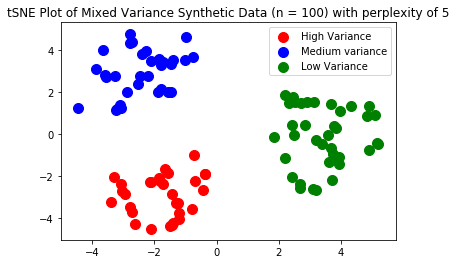

In [0]:
x2 = Y2[:, 0]
y2 = Y2[:, 1]
label_dict = {0: 'High Variance', 1: 'Medium variance', 2: 'Low Variance'}
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
fig, ax = plt.subplots()
for label in np.unique(labels2):
    index = np.where(labels2 == label)
    ax.scatter(x2[index], y2[index], c = color_dict[label], label = label_dict[label], s = 100)
ax.legend()
plt.title("tSNE Plot of Mixed Variance Synthetic Data (n = 100) with perplexity of 5")
plt.show()

In [0]:
# Here we choose a perplexity of 20
Y3 = tsne(synthetic_data2, 20, 200, 10)

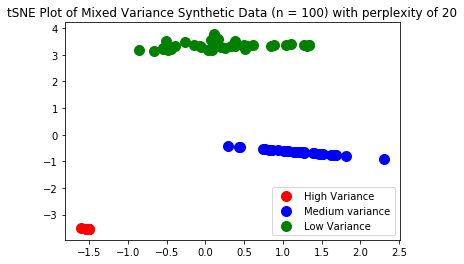

In [0]:
x3 = Y3[:, 0]
y3 = Y3[:, 1]
label_dict = {0: 'High Variance', 1: 'Medium variance', 2: 'Low Variance'}
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
fig, ax = plt.subplots()
for label in np.unique(labels2):
    index = np.where(labels2 == label)
    ax.scatter(x3[index], y3[index], c = color_dict[label], label = label_dict[label], s = 100)
ax.legend()
plt.title("tSNE Plot of Mixed Variance Synthetic Data (n = 100) with perplexity of 20")
plt.show()

Below we do the PCA plot for this data

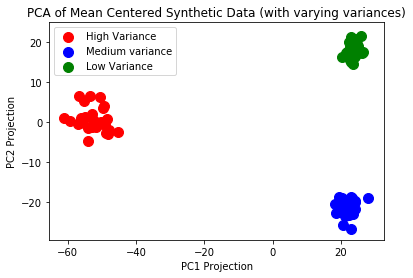

In [0]:
# First, we mean center the data
# We do this by updating each row (subtracting the row mean from each value in the row)
D2 = np.transpose(synthetic_data2).copy()
for row_index in range(len(D2)):
    row_mean = np.mean(synthetic_data2[:,row_index])
    D2[row_index,:] = [x - row_mean for x in synthetic_data2[:,row_index]]
    
# Now we calculate the mean-centered co-variance matrix
# Note that we have m = 100 total cells
m2 = 100
sigma2 = (1.0 / (m2 - 1)) * (np.matmul(D2, np.transpose(D2)))

eig_values2, eig_vectors2 = np.linalg.eig(sigma2)
# this is to sort the eigen values/vecotrs
idx2 = eig_values2.argsort()[::-1]   
eigenValues2 = eig_values2[idx2]
eigenVectors2 = eig_vectors2[:,idx2]

# Here we project the mean centered data D2 along the first and second eigenvectors
projection_pc1b = np.matmul(np.transpose(eigenVectors2[:,0]), D2)
projection_pc2b = np.matmul(np.transpose(eigenVectors2[:,1]), D2)

fig, ax = plt.subplots()
for label in np.unique(labels2):
    index = np.where(labels2 == label)
    ax.scatter(projection_pc1b[index], projection_pc2b[index], c = color_dict[label], label = label_dict[label], s = 100)
ax.legend()
plt.xlabel("PC1 Projection")
plt.ylabel("PC2 Projection")
plt.title("PCA of Mean Centered Synthetic Data (with varying variances)")
plt.show()

# Synthetic Data Analysis where one component accounts for 50% of data

Now we generate synthetic data where all the mixture components have the same covariance matrix. 
The centroids are still well separated. But now the points come disproportionally from each distribution/mixture component. Now points are twice as likely to come from the first component as the second or third component (50-25-25 split)

In [0]:
centroids3 = [[0,0,0,0,0,0,0,0,0,0], [15,7,15,7,15,7,15,7,15,7], [7,15,7,15,7,15,7,15,7,15]]
covs3 = [np.diag((3, 3, 3, 3, 3, 3, 3, 3, 3, 3)), np.diag((3, 3, 3, 3, 3, 3, 3, 3, 3, 3)), np.diag((3, 3, 3, 3, 3, 3, 3, 3, 3, 3))]

In [0]:
synthetic_data3, labels3 = generatePoints(100, centroids2, covs2, 2, 1, 1)

In [0]:
# Here we choose a perplexity of 5
Y4 = tsne(synthetic_data3, 5, 200, 10)

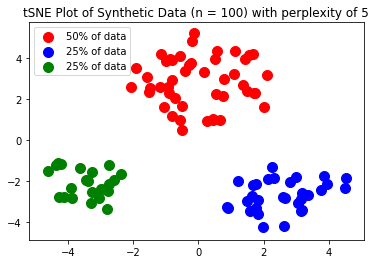

In [0]:
x4 = Y4[:, 0]
y4 = Y4[:, 1]
label_dict2 = {0: '50% of data', 1: '25% of data', 2: '25% of data'}
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
fig, ax = plt.subplots()
for label in np.unique(labels3):
    index = np.where(labels3 == label)
    ax.scatter(x4[index], y4[index], c = color_dict[label], label = label_dict2[label], s = 100)
ax.legend()
plt.title("tSNE Plot of Synthetic Data (n = 100) with perplexity of 5")
plt.show()

In [0]:
# Here we choose a perplexity of 20
Y5 = tsne(synthetic_data3, 20, 200, 10)

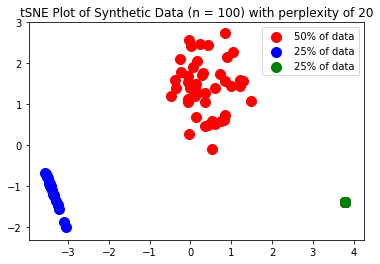

In [0]:
x5 = Y5[:, 0]
y5 = Y5[:, 1]

fig, ax = plt.subplots()
for label in np.unique(labels3):
    index = np.where(labels3 == label)
    ax.scatter(x5[index], y5[index], c = color_dict[label], label = label_dict2[label], s = 100)
ax.legend()
plt.title("tSNE Plot of Synthetic Data (n = 100) with perplexity of 20")
plt.show()

Below we do PCA for this data

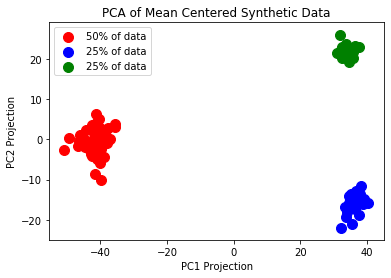

In [0]:
# First, we mean center the data
# We do this by updating each row (subtracting the row mean from each value in the row)
D3 = np.transpose(synthetic_data3).copy()
for row_index in range(len(D3)):
    row_mean = np.mean(synthetic_data3[:,row_index])
    D3[row_index,:] = [x - row_mean for x in synthetic_data3[:,row_index]]
    
# Now we calculate the mean-centered co-variance matrix
# Note that we have m = 100 total cells
m3 = 100
sigma3 = (1.0 / (m3 - 1)) * (np.matmul(D3, np.transpose(D3)))

eig_values3, eig_vectors3 = np.linalg.eig(sigma3)
# this is to sort the eigen values/vecotrs
idx3 = eig_values3.argsort()[::-1]   
eigenValues3 = eig_values3[idx3]
eigenVectors3 = eig_vectors3[:,idx3]

# Here we project the mean centered data D2 along the first and second eigenvectors
projection_pc1c = np.matmul(np.transpose(eigenVectors3[:,0]), D3)
projection_pc2c = np.matmul(np.transpose(eigenVectors3[:,1]), D3)

fig, ax = plt.subplots()
for label in np.unique(labels3):
    index = np.where(labels3 == label)
    ax.scatter(projection_pc1c[index], projection_pc2c[index], c = color_dict[label], label = label_dict2[label], s = 100)
ax.legend()
plt.xlabel("PC1 Projection")
plt.ylabel("PC2 Projection")
plt.title("PCA of Mean Centered Synthetic Data")
plt.show()

# Analysis of Synthetic Data Results (tSNE and PCA)

From the plots above, the first thing I observe is that as we increase the perplexity of t-SNE, the clusters get closer together. 

We see that the area of a tSNE blob is not indicative of the density of (or the amount of points in) the cluster. This is most clearly seen in the tSNE plot with perplexity 20 where 25% of the data is from the third distribution (green), but it is condensed into a tiny cluster in the plot, while blue cluster (representing the same percentage of the data) is much larger in size. This is because minimizing the tSNE cost function (well technically it has more to do with how we define the probability distributions $p_{j|i}$, whith the $\sigma_i$ term, but also with the fact that we find a low-dimensional representation that preserves neighborhood clustering) pulls points that are close together even closer together (relative to $\sigma_i$ and the perplexity) and points that are further apart even further apart. Especially with large perplexity, we see that we tend to consider more points to be "close" together, so they get drawn to their nearest cluster (which in turn makes the cluster even smaller, despite having more points). 

So we might think then that the variance of the data might be reflected by the tSNE blob size. It doesn't really appear to be the case with a perplexity of 5, but it does appear to be the case with a perplexity of 20, where the more variance a component in the Gaussian Mixture model has, the smaller the cluster of points that come from it is. Intutitively though, does this make sense? Well, we can think of variance as how much the points vary from the centroid on average (so it is effectively telling us distances). We chose the centroids and variances such that we shouldn't get any overlap in the clusters (they are clearly separated from each other in the synthetic data). So even with the high variance (at least in this case the way the centroids are chosen), tSNE should still be able to recognize which points belong to the same cluster and moreover, again because the perplexity (and thus the $\sigma_i$'s) means that we judge distances between neighboring points locally, rather than globally, this shouldn't matter. This is why even with high variance (and thus with the points being far apart in the high dimensional space), the points in the red cluster in the tSNE plot (with perplexity 20) are close together in a small cluster. So is there any reason the cluster is the smallest according to the cost function? No, minimizing the tSNE cost function simply ensures that we preserve "neighborhoods". The size of the cluster as mentioned before, has more to do with $\sigma_i$ and the chosen perplexity as even points that are further away (because of high variance) are still neighbors to each other with high perplexity, so the tSNE plot pulls them close together. 

Having said all this, what does the size of the tSNE blobs represent? Well we see that they vary a lot with the chosen perplexity and we keep mentioning that the perplexity is the reason that distances and density in high dimensional data are not necessarily reflected in the low-dimensional representation. And in fact, perplexity is what determines the size of the clusters. We can get tiny, dense clusters by choosing a very high perplexity (> 50) and we can get large clusters (with more spread out points) with small perplexity (< 5). This is because a high perplexity means that neighbors can have larger distances between them in the high dimensional space and still be considered "neighbors", which in turn means that minimizing the cost function involves getting these points artificially close together in the low-dimensional space. 

What about the cluster area/volume (if plotting 3 principal components) in the PCA plot? Well PCA simply tries to preserve the variance found in the high-dimensional space when projecting the data into lower dimensions. So we expect that the area/volume of each blob represents the variance of the points in the cluster along each principal dimension. So if we increase the variance, we expect larger blobs and similarly, if we increase the number of points, we expect more points to vary from the centroid, leading to larger blobs